# Reinforcement Learning Project: Control in a Continuous Action Space with DDPG

In this project, we will explore the Deep Deterministic Policy Gradient (DDPG) algorithm, which is designed to handle continuous action spaces in Reinforcement Learning. We will use the Pendulum-v1 environment implemented in OpenAI Gym to implement the DDPG algorithm from scratch to solve the classical control problem of stabilizing an inverted pendulum. Throughout the development, we will incrementally build the components of DDPG and analyze their importance for correct and effective learning. This Jupyter notebook contains our implementation and report for this project. 

The instructions are available in `Miniproject_DDPG.pdf` file.

In [57]:
import numpy as np
import gym
from helpers import NormalizedEnv
from helpers import RandomAgent

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import deque


In [58]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## Heuristic policy

In [59]:
# Create environement instance, an instance of the Pendulum-v1 environment wrapped in a NormalizedEnv class
# to normalize the action space between -1 and 1
env = gym.make('Pendulum-v1', render_mode='rgb_array')
env = NormalizedEnv(env)

# Create a RandomAgent
random_agent = RandomAgent(env)

# Function that run the agent for a given number of episodes and return the average reward
def run_agent(agent, env, num_episodes):
    rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        while True:
            action = agent.compute_action(state)
            state, reward, _, trunc, _ = env.step(action)
            episode_reward += reward
            if trunc:
                break
        rewards.append(episode_reward)
    return np.mean(rewards)
average_reward = run_agent(random_agent, env, 10)
print('Average reward over 10 episodes: {}'.format(average_reward))

Average reward over 10 episodes: -1124.1860077764259


In [60]:
class HeuristicPendulumAgent:
    def __init__(self, env: NormalizedEnv, torque_intensity: float=1.0) -> None:
        """Heuristic agent for the Pendulum-v1 environment."""
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.torque_intensity = torque_intensity
        
    def compute_action(self, state):
        """Compute the action to apply to the environment.

        When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity.
        When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.
        """
        action = np.where(state[..., 0] < 0, # If the pendulum is in the lower half of the circle
                        np.sign(state[..., 2]) * self.torque_intensity, 
                        -np.sign(state[..., 2]) * self.torque_intensity)
        return action


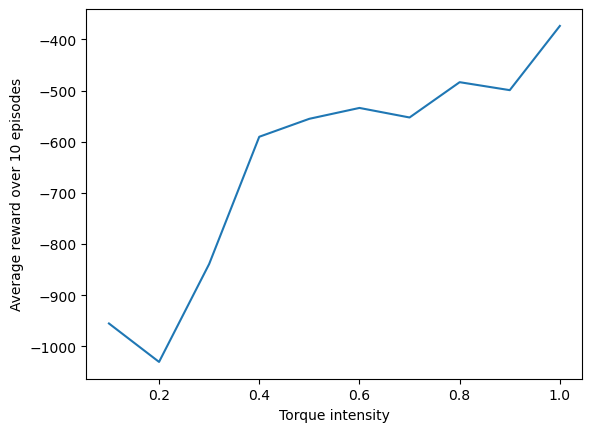

Best torque intensity: 1.0
Best reward over 10 episodes: -373.7062101434721


In [61]:
# Find best torque intensity
torque_intensities = np.linspace(0.1, 1, 10)
rewards = []
for torque_intensity in torque_intensities:
    heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensity)
    rewards.append(run_agent(heuristic_agent, env, 10))

plt.plot(torque_intensities, rewards)
plt.xlabel('Torque intensity')
plt.ylabel('Average reward over 10 episodes')
plt.show()

# Create a HeuristicPendulumAgent with the best torque intensity
heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensities[np.argmax(rewards)])
# Print best reward over 10 episodes and associated torque intensity
print('Best torque intensity: {}'.format(torque_intensities[np.argmax(rewards)]))
print('Best reward over 10 episodes: {}'.format(np.max(rewards)))


In [62]:
# Animation of the Heuristic Agent using PIL
state, _ = env.reset()
frames = []
while True:
    action = heuristic_agent.compute_action(state)
    state, reward, _, trunc, _ = env.step(action)
    frames.append(env.render())
    if trunc:
        break

frames = np.array(frames)
frames = [Image.fromarray(frame) for frame in frames]
frames[0].save("heuristic_agent.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)


## Q function of the heuristic policy

In [63]:
transition_type = np.dtype([('state', np.float32, (3,)),
                            ('action', np.float32, (1,)),
                            ('reward', np.float32, (1,)),
                            ('next_state', np.float32, (3,)),
                            ('trunc', bool, (1,))])

# test transition type from simulation
state, _ = env.reset()
action = heuristic_agent.compute_action(state)
next_state, reward, _, trunc, _ = env.step(action)
transition = np.array((state, action, reward, next_state, trunc), dtype=transition_type)
# Do a 2nd step
state = next_state
action = heuristic_agent.compute_action(state)
next_state, reward, _, trunc, _ = env.step(action)
transition = np.array((state, action, reward, next_state, trunc), dtype=transition_type)

print(transition)
print(transition['state'])
print(transition['action'])
print(transition['reward'])
print(transition['next_state'])
print(transition['trunc'])



([0.73982763, 0.6727965 , 0.40871733], [-1.], [-0.56532276], [0.7188512 , 0.69516397, 0.6133147 ], [False])
[0.73982763 0.6727965  0.40871733]
[-1.]
[-0.56532276]
[0.7188512  0.69516397 0.6133147 ]
[False]


In [64]:
# Type of a transition. To be used to create a numpy array of transitions.
# Example of a transition:
#   transition = np.array((state, action, reward, next_state, trunc), dtype=transition_type)
transition_type = np.dtype([('state', np.float32, (3,)),
                    ('action', np.float32, (1,)),
                    ('reward', np.float32, (1,)),
                    ('next_state', np.float32, (3,)),
                    ('trunc', bool, (1,))])


class NewReplayBuffer:
    def __init__(self, capacity: int, transition_type: np.dtype) -> None:
        """Buffer to store transitions.

        The buffer is implemented as a cyclic (of size `capacity`) numpy array of transitions. 
        A transition is a structured array with the following fields:
            state (np.ndarray[(3,), np.float]): State of the environment.
            action (np.ndarray[(1,), np.float32]): Action applied to the environment.
            reward (np.ndarray[(1,), np.float32]): Reward obtained after applying the action.
            next_state (np.ndarray[(3,), np.float32]): State of the environment after applying the action.
            trunc (np.ndarray[(1,), np.bool]): Boolean indicating if the episode is truncated.
        When the buffer is full, the oldest transitions are dropped.
        
        
        Args:
            capacity (int): Capacity of the buffer.
            transition_type (np.dtype): Type of the transitions to store.
        """
        # Maximum number of transitions to store in the buffer. 
        # When the buffer overflows the old memories are dropped.
        self.capacity = capacity 
        # Numpy array of transitions
        self.buffer = np.zeros(capacity, dtype=transition_type)
        # Index of the next transition to be stored
        self.index = 0
        # Current size of the buffer
        self.size = 0

    def push(self, transition: np.ndarray) -> None:
        """Add a transition to the buffer."""
        self.buffer[self.index] = transition
        self.index = (self.index + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int) -> np.ndarray:
        """Sample a batch of size `batch_size` of transitions from the buffer."""
        indices = np.random.choice(self.size, batch_size, replace=False)
        return self.buffer[indices]

    def __len__(self) -> int:
        return self.size
    
# Test buffer
buffer = NewReplayBuffer(10, transition_type)
for i in range(10):
    buffer.push(transition)
print(buffer.sample(5)['state'])
print(buffer.sample(5)['action'])
print(buffer.sample(5)['reward'])
print(buffer.sample(5)['next_state'])
print(buffer.sample(5)['trunc'])



[[0.73982763 0.6727965  0.40871733]
 [0.73982763 0.6727965  0.40871733]
 [0.73982763 0.6727965  0.40871733]
 [0.73982763 0.6727965  0.40871733]
 [0.73982763 0.6727965  0.40871733]]
[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
[[-0.56532276]
 [-0.56532276]
 [-0.56532276]
 [-0.56532276]
 [-0.56532276]]
[[0.7188512  0.69516397 0.6133147 ]
 [0.7188512  0.69516397 0.6133147 ]
 [0.7188512  0.69516397 0.6133147 ]
 [0.7188512  0.69516397 0.6133147 ]
 [0.7188512  0.69516397 0.6133147 ]]
[[False]
 [False]
 [False]
 [False]
 [False]]


In [65]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """Replay buffer used to store a sequence of transitions.

        A transition is a numpy structured array with the fields detailed in the transition_type variable.
        """
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def __len__(self):
        return len(self.buffer)

    def store(self, transition: tuple):
        """Store a transition in the buffer."""
        self.buffer.append(transition)

    def sample(self, batch_size: int=128) -> list:
        """Sample a batch of transitions from the buffer."""
        indexes = np.random.randint(len(self.buffer), size=batch_size)
        """return np.asarray(self.buffer)[indexes]"""
        """return np.random.choice(np.asarray(self.buffer), batch_size, replace=False)"""

        """return np.random.choice(self.buffer, batch_size, replace=False)"""

        batch = []
        """indexes = np.sort(np.random.choice(len(self.buffer), 
                                           size=min(batch_size, len(self.buffer)), 
                                           replace=False))[::-1]"""
        for index in indexes:
            batch.append(self.buffer[index])
            #self.buffer.pop(index)
        return batch


class QNetwork(nn.Module):
    def __init__(self, state_size: int=3, action_size: int=1):
        """QNetwork. Maps (state, action) pairs to Q-values."""
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state, action):
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor
            action (torch.Tensor): Action tensor

        Returns:
            q_value (torch.Tensor): Q-value tensor
        """
        
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def TD_learning_update(q_network, agent, optimizer, transitions, gamma):
    """Perform a 1-step TD-learning update for a batch of transitions.

    Args:
        q_network (QNetwork): QNetwork instance
        agent (Agent): Agent (i.e. Policy) instance
        optimizer (torch.optim): Optimizer instance
        transitions (List[Transition]): Batch of transitions
        gamma (float): Discount factor

    Returns:
        loss (float): Loss value
    """
    # Iterate over all the transitions and store each state, 
    # action, reward, next_state and trunc in a numpy array
    states = []
    actions = []
    rewards = []
    next_states = []
    truncs = []
    for transition in transitions:
        states.append(transition[0])
        actions.append(transition[1])
        rewards.append(transition[2])
        next_states.append(transition[3])
        truncs.append(transition[4])
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    truncs = np.array(truncs)

    # Convert the numpy arrays to torch tensors
    # Note: We choose the convention that all the tensors are of shape 
    # (batch_size, *), where * is the shape of the data and of dtype
    # torch.float32, except for truncs which is of dtype torch.bool
    states_t = torch.from_numpy(states).float()
    actions_t = torch.from_numpy(actions)[:, None].float()
    rewards_t = torch.from_numpy(rewards)[:, None].float()
    next_states_t = torch.from_numpy(next_states).float()
    truncs_t = torch.from_numpy(truncs)[:, None].bool()


    with torch.no_grad():
        next_actions = agent.compute_action(next_states)
        next_actions_t = torch.as_tensor(next_actions)[:, None].float()
        # Naive next Q-values (i.e. without taking truncation into account)
        naive_next_qs = q_network(next_states_t, next_actions_t)
        # Actual next Q-values (i.e. taking truncation into account)
        next_qs = torch.where(truncs_t, 
                              torch.zeros_like(rewards_t), 
                              naive_next_qs)
        gamma = torch.tensor(gamma, dtype=torch.float32)
        targets = rewards_t + gamma * next_qs

    loss = F.mse_loss(q_network(states_t, actions_t), targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


In [66]:
max_size = 10000
replay_buffer = ReplayBuffer(max_size=max_size)
q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0])
optimizer = torch.optim.SGD(q_network.parameters(), lr=1e-4)
gamma = 0.99

"""
Check dimensionality before and after buffer
Check also just at the beginning of the forward method, at the error computation
"""

# Training loop for the Q-learning
losses = []
for episode in range(1000):
    state, _ = env.reset()
    while True:
        # Simulation step
        action = heuristic_agent.compute_action(state)
        next_state, reward, _, trunc, _ = env.step(action)
        replay_buffer.store((state, action, reward, next_state, trunc))
        # Training step
        if len(replay_buffer) >= max_size:
            transitions = replay_buffer.sample(128)
            loss = TD_learning_update(q_network, heuristic_agent, optimizer, transitions, gamma)
            losses.append(loss.item())

        if trunc:
            break
        state = next_state
    # Print the average (over the last episode) loss every 10 episodes
    if episode % 10 == 0 and len(losses) > 0:
        print(f'Episode {episode} - Median loss: {np.median(losses[-2000:])}')

plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()


Episode 50 - Median loss: 19.029468536376953
Episode 60 - Median loss: 37.98786163330078
Episode 70 - Median loss: 35.158348083496094
Episode 80 - Median loss: 31.29254913330078
Episode 90 - Median loss: 28.50917625427246
Episode 100 - Median loss: 23.571303367614746
Episode 110 - Median loss: 23.66153335571289
Episode 120 - Median loss: 22.12875747680664
Episode 130 - Median loss: 25.208121299743652
Episode 140 - Median loss: 28.044541358947754
Episode 150 - Median loss: 29.45437717437744
Episode 160 - Median loss: 28.64589500427246
Episode 170 - Median loss: 24.438267707824707
Episode 180 - Median loss: 23.67254066467285
Episode 190 - Median loss: 22.315953254699707
Episode 200 - Median loss: 21.020941734313965
Episode 210 - Median loss: 23.92364501953125
Episode 220 - Median loss: 20.374723434448242
Episode 230 - Median loss: 21.472095489501953
Episode 240 - Median loss: 24.480103492736816
Episode 250 - Median loss: 25.63819694519043
Episode 260 - Median loss: 25.406719207763672
Epi

KeyboardInterrupt: 

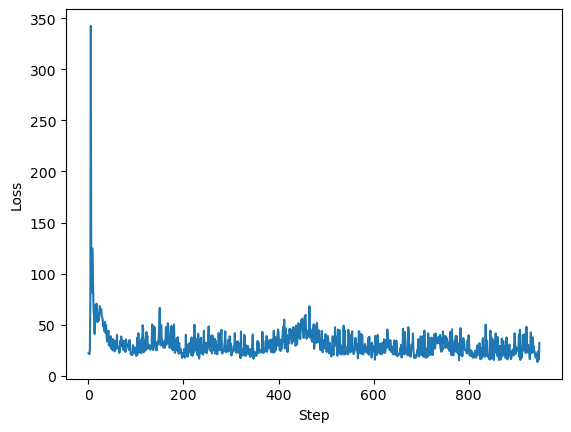

In [ ]:
#plot mean losses over windows of size 2000
#plt.plot([np.mean(losses[i:i+2000]) for i in range(len(losses))])
# Plot mean losses over batch of 2000
size = 200
plt.plot([np.median(losses[i:i+size]) for i in range(0, len(losses)-size, size)])

plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [ ]:
backup_losses = losses